# Deep Learning - Assignment 5: CNN

## Todo:

* (70 pts) Using Keras, implement the CNN architecture depictedin the following figure.
* (10 pts) Train and test your implemented model in the Cats vsNon-Cat dataset used in previous assignments.
* (20 pts) Use regularization and optimization mechanisms toreduce the bias and variance of the neural network. Brieflydiscuss the results.

<img src="https://i.ibb.co/HFHswj8/architecture.jpg" width="800px"/>

# Read original dataset and resize to (224x224)px

## Train data

In [2]:
import h5py
filename = 'datasets/train_catvnoncat.h5'
f = h5py.File(filename, 'r')

# list(f.keys())

data = list(f['train_set_x'])

import numpy as np
X_tr=np.array(data)

from PIL import Image as im
idx = 0

tmp1 = list(f['list_classes'])
tmp2 = list(f['train_set_y'])

for x in X_tr:
    data = im.fromarray(x)
    data = data.resize((224, 224))
    name = str(tmp1[tmp2[idx]]).split("'")[1]
    data.save(f"input/train/{name}.{idx}.jpg")
    idx += 1

## Test data

In [3]:
file = 'datasets/test_catvnoncat.h5'
fil = h5py.File(file, 'r')

group_key = list(fil.keys())

# group_key

test=np.array(fil['test_set_x'])

from PIL import Image as im
idx = 0

tmp1 = list(fil['list_classes'])
tmp2 = list(fil['test_set_y'])

for x in test:
    data = im.fromarray(x)
    data = data.resize((224, 224))
    name = str(tmp1[tmp2[idx]]).split("'")[1]
    data.save(f"input/test/{name}.{idx}.jpg")
    idx += 1

# Import Libraries

For pre-processing

In [4]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import random
import os

For keras model

In [5]:
from tensorflow.keras import models, layers, losses, regularizers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

For accuracy metric

In [6]:
from sklearn.metrics import accuracy_score

# Define Constants

In [7]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Traning Data

In [8]:
filenames = os.listdir("input/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'cat':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [9]:
df.head()

,filename,category
0,cat.102.jpg,1
1,cat.104.jpg,1
2,cat.106.jpg,1
3,cat.107.jpg,1
4,cat.108.jpg,1


In [10]:
df.tail()

,filename,category
204,non-cat.91.jpg,0
205,non-cat.95.jpg,0
206,non-cat.96.jpg,0
207,non-cat.98.jpg,0
208,non-cat.99.jpg,0


### See Total In count

<AxesSubplot:>

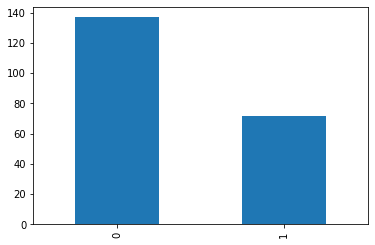

In [11]:
df['category'].value_counts().plot.bar()

Total size of train: 209

# See sample image

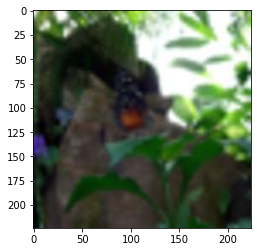

In [12]:
sample = random.choice(filenames)
image = load_img("input/train/"+sample)
plt.imshow(image)

# Model

* **Input Layer**: Input size is 224x224.

**Hidden Layers:**
1. **Conv** - Filters: 96, size: 7, strides: 2. Activation = ReLU. MaxPooling: (3x3), strides: 2. 
2. **Conv** - Filters: 256, size: 5, strides: 2. MaxPooling: (3x3), strides: 2. Activation = ReLU.
3. **Conv** - Filters: 384, size: 3, strides: 1. Activation = ReLU. **Dropout** with 20% drop probability.
4. **Conv** - Filters: 384, size: 3, strides: 1. Activation = ReLU. **Dropout** with 20% drop probability.
5. **Conv** - Filters: 256, size: 3, strides: 1. Activation = ReLU. MaxPooling: (3x3), strides: 2. Flatten to 2D.
6. **Dense** - Units: 4096.
7. **Dense** - Units: 4096.

* **Output Layer**: Activation = Softmax. Predicted class out of the two available: cat or non-cat. 

**Optimizer**: Stochastic Gradient Descent with Learning Rate = 0.001

In [13]:
model = Sequential()

# Layer 1
model.add(ZeroPadding2D(padding=1, input_shape = (224, 224, 3)))
model.add(Conv2D(filters = 96, kernel_size = 7, strides = 2, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (3, 3), strides = 2, padding='same'))
#model.add(BatchNormalization())

# Layer 2
model.add(Conv2D(filters = 256, kernel_size = 5, strides = 2, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(3, 3), strides = 2, padding='same'))
#model.add(BatchNormalization())

# Layer 3
model.add(Conv2D(filters = 384, kernel_size = 3, strides = 1, activation = 'relu', padding='same'))
model.add(Dropout(0.2))
#model.add(BatchNormalization())

# Layer 4
model.add(Conv2D(filters = 384, kernel_size = 3, strides=1, activation = 'relu', padding='same'))
model.add(Dropout(0.2))
#model.add(BatchNormalization())

# Layer 5
model.add(Conv2D(filters = 256, kernel_size = 3, strides=1, activation = 'relu', padding='same'))
#model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (3, 3), strides = 2))
#model.add(BatchNormalization())

# Layer 6
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
#model.add(Dropout(0.5))

# Layer 7
model.add(Dense(4096, activation='relu'))
#model.add(Dropout(0.5))

# Layer 8
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes


model.compile(optimizer=optimizers.SGD(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 110, 110, 96)      14208     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 384)       0

# Callbacks

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=50, 
                                            cooldown=20,
                                            verbose=1, 
                                            factor=0.05, 
                                            min_lr=1e-08)

In [15]:
# make sure that the model corresponding to the best epoch is saved
checkpointer = ModelCheckpoint(filepath='model.h5',
                               monitor='val_accuracy',
                               save_best_only=True,
                               verbose=0)

In [16]:
callbacks = [learning_rate_reduction, checkpointer]

# Prepare data

We use an image generator with class_mode="categorical", thus category column is to be transformed to a string so the generator applies one-hot encoding.

In [17]:
df["category"] = df["category"].replace({1: 'cat', 0: 'noncat'}) 

In [18]:
df.head()

,filename,category
0,cat.102.jpg,cat
1,cat.104.jpg,cat
2,cat.106.jpg,cat
3,cat.107.jpg,cat
4,cat.108.jpg,cat


Stratified train-test split

In [20]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in sss.split(df['filename'], df['category']):
    X_train, X_test = df['filename'][train_index], df['category'][train_index]
    y_train, y_test = df['filename'][test_index], df['category'][test_index]

train_df = df.copy()
validate_df = df.copy()

train_df['filename'] = None
train_df['category'] = None
validate_df['filename'] = None
validate_df['category'] = None

train_df['filename'] = X_train.reset_index(drop=True)
train_df['category'] = X_test.reset_index(drop=True)
validate_df['filename'] = y_train.reset_index(drop=True)
validate_df['category'] = y_test.reset_index(drop=True)

train_df.dropna(inplace=True)
validate_df.dropna(inplace=True)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

display(f"TRAIN: {len(train_df)}")
display(f"TEST: {len(validate_df)}")

'TRAIN: 146'

'TEST: 63'

<AxesSubplot:>

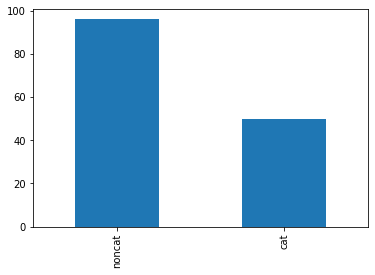

In [21]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

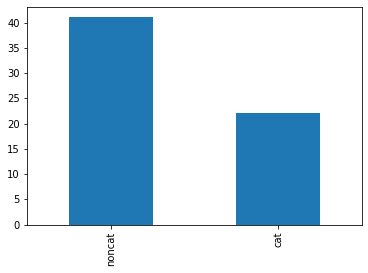

In [22]:
validate_df['category'].value_counts().plot.bar()

In [23]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=1

# Traning Generator

In [24]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    seed = 42
)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
display(label_map)

# for x, y in train_generator:
#     print(y[0])
#     plt.imshow(x[0])
#     break

Found 146 validated image filenames belonging to 2 classes.


{0: 'cat', 1: 'noncat'}

### Validation Generator

In [25]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    seed = 42
)

label_map = dict((v,k) for k,v in validation_generator.class_indices.items())
display(label_map)

# for x, y in validation_generator:
#     print(y[0])
#     plt.imshow(x[0])
#     break

Found 63 validated image filenames belonging to 2 classes.


{0: 'cat', 1: 'noncat'}

### Example Generator

In [26]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


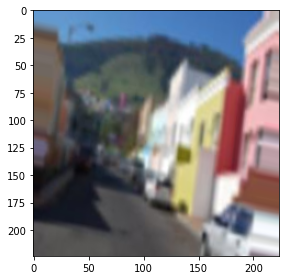

In [27]:
for X_batch, Y_batch in example_generator:
    image = X_batch[0]
    plt.imshow(image)
    break
plt.tight_layout()
plt.show()

# Fit Model

In [28]:
epochs=3 if FAST_RUN else 500
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/500
146/146 [==============================] - 10s 29ms/step - loss: 0.6843 - accuracy: 0.6611 - val_loss: 0.6723 - val_accuracy: 0.6508
Epoch 2/500
146/146 [==============================] - 2s 15ms/step - loss: 0.6672 - accuracy: 0.6258 - val_loss: 0.6558 - val_accuracy: 0.6508
Epoch 3/500
146/146 [==============================] - 2s 15ms/step - loss: 0.6510 - accuracy: 0.6466 - val_loss: 0.6469 - val_accuracy: 0.6508
Epoch 4/500
146/146 [==============================] - 2s 15ms/step - loss: 0.6233 - accuracy: 0.6796 - val_loss: 0.6435 - val_accuracy: 0.6508
Epoch 5/500
146/146 [==============================] - 2s 16ms/step - loss: 0.6112 - accuracy: 0.7027 - val_loss: 0.6460 - val_accuracy: 0.6508
Epoch 6/500
146/146 [==============================] - 2s 15ms/step - loss: 0.6427 - accuracy: 0.6410 - val_loss: 0.6417 - val_accuracy: 0.6508
Epoch 7/500
146/146 [==============================] - 2s 16ms/step - loss: 0.6311 - accuracy: 0.6643 - val_loss: 0.6378 - val_accuracy

146/146 [==============================] - 2s 15ms/step - loss: 0.3057 - accuracy: 0.8875 - val_loss: 0.3729 - val_accuracy: 0.8413
Epoch 58/500
146/146 [==============================] - 2s 15ms/step - loss: 0.3478 - accuracy: 0.8651 - val_loss: 0.3864 - val_accuracy: 0.8254
Epoch 59/500
146/146 [==============================] - 2s 15ms/step - loss: 0.2598 - accuracy: 0.9250 - val_loss: 0.4055 - val_accuracy: 0.7937
Epoch 60/500
146/146 [==============================] - 2s 15ms/step - loss: 0.3230 - accuracy: 0.8848 - val_loss: 0.4127 - val_accuracy: 0.8095
Epoch 61/500
146/146 [==============================] - 2s 15ms/step - loss: 0.2956 - accuracy: 0.8672 - val_loss: 0.3965 - val_accuracy: 0.8095
Epoch 62/500
146/146 [==============================] - 2s 15ms/step - loss: 0.2821 - accuracy: 0.8802 - val_loss: 0.3842 - val_accuracy: 0.8571
Epoch 63/500
146/146 [==============================] - 2s 15ms/step - loss: 0.3508 - accuracy: 0.8765 - val_loss: 0.4070 - val_accuracy: 0.809

Epoch 113/500
146/146 [==============================] - 2s 16ms/step - loss: 0.1900 - accuracy: 0.9448 - val_loss: 0.3362 - val_accuracy: 0.8413
Epoch 114/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2200 - accuracy: 0.9083 - val_loss: 0.3364 - val_accuracy: 0.8413
Epoch 115/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2553 - accuracy: 0.9146 - val_loss: 0.3364 - val_accuracy: 0.8413
Epoch 116/500
146/146 [==============================] - 2s 16ms/step - loss: 0.1973 - accuracy: 0.9244 - val_loss: 0.3364 - val_accuracy: 0.8413
Epoch 117/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2358 - accuracy: 0.9113 - val_loss: 0.3348 - val_accuracy: 0.8413
Epoch 118/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2058 - accuracy: 0.9404 - val_loss: 0.3356 - val_accuracy: 0.8413
Epoch 119/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2749 - accuracy: 0.9098 - val_loss: 0.3364 -

146/146 [==============================] - 2s 16ms/step - loss: 0.1643 - accuracy: 0.9305 - val_loss: 0.3326 - val_accuracy: 0.8571
Epoch 169/500
146/146 [==============================] - 3s 17ms/step - loss: 0.1846 - accuracy: 0.9367 - val_loss: 0.3325 - val_accuracy: 0.8571
Epoch 170/500
146/146 [==============================] - 2s 16ms/step - loss: 0.1976 - accuracy: 0.9372 - val_loss: 0.3325 - val_accuracy: 0.8571
Epoch 171/500
146/146 [==============================] - 2s 17ms/step - loss: 0.1954 - accuracy: 0.9244 - val_loss: 0.3324 - val_accuracy: 0.8571
Epoch 172/500
146/146 [==============================] - 2s 15ms/step - loss: 0.2225 - accuracy: 0.9089 - val_loss: 0.3326 - val_accuracy: 0.8571
Epoch 173/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2191 - accuracy: 0.9170 - val_loss: 0.3325 - val_accuracy: 0.8571
Epoch 174/500
146/146 [==============================] - 2s 15ms/step - loss: 0.1843 - accuracy: 0.9364 - val_loss: 0.3325 - val_accuracy:

146/146 [==============================] - 2s 15ms/step - loss: 0.1994 - accuracy: 0.9400 - val_loss: 0.3313 - val_accuracy: 0.8571
Epoch 225/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2190 - accuracy: 0.9276 - val_loss: 0.3313 - val_accuracy: 0.8571
Epoch 226/500
146/146 [==============================] - 3s 17ms/step - loss: 0.2130 - accuracy: 0.9470 - val_loss: 0.3312 - val_accuracy: 0.8571

Epoch 00226: ReduceLROnPlateau reducing learning rate to 1.2500000821091816e-07.
Epoch 227/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2112 - accuracy: 0.9282 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 228/500
146/146 [==============================] - 2s 15ms/step - loss: 0.2331 - accuracy: 0.8912 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 229/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2915 - accuracy: 0.8669 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 230/500
146/146 [==============================] -

146/146 [==============================] - 2s 16ms/step - loss: 0.1610 - accuracy: 0.9440 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 280/500
146/146 [==============================] - 2s 16ms/step - loss: 0.1883 - accuracy: 0.9294 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 281/500
146/146 [==============================] - 3s 17ms/step - loss: 0.1623 - accuracy: 0.9625 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 282/500
146/146 [==============================] - 2s 17ms/step - loss: 0.2070 - accuracy: 0.9239 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 283/500
146/146 [==============================] - 2s 16ms/step - loss: 0.1885 - accuracy: 0.9023 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 284/500
146/146 [==============================] - 2s 15ms/step - loss: 0.1782 - accuracy: 0.9288 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 285/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2388 - accuracy: 0.9334 - val_loss: 0.3312 - val_accuracy:

146/146 [==============================] - 2s 15ms/step - loss: 0.2344 - accuracy: 0.9293 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 335/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2363 - accuracy: 0.9092 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 336/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2334 - accuracy: 0.8948 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 337/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2459 - accuracy: 0.9095 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 338/500
146/146 [==============================] - 2s 16ms/step - loss: 0.1899 - accuracy: 0.9260 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 339/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2332 - accuracy: 0.9235 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 340/500
146/146 [==============================] - 2s 16ms/step - loss: 0.1809 - accuracy: 0.9491 - val_loss: 0.3312 - val_accuracy:

146/146 [==============================] - 2s 17ms/step - loss: 0.2399 - accuracy: 0.9166 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 391/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2091 - accuracy: 0.9087 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 392/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2642 - accuracy: 0.8752 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 393/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2453 - accuracy: 0.8911 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 394/500
146/146 [==============================] - 2s 15ms/step - loss: 0.2223 - accuracy: 0.8820 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 395/500
146/146 [==============================] - 2s 16ms/step - loss: 0.1590 - accuracy: 0.9510 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 396/500
146/146 [==============================] - 3s 17ms/step - loss: 0.1745 - accuracy: 0.9230 - val_loss: 0.3312 - val_accuracy:

146/146 [==============================] - 3s 21ms/step - loss: 0.2558 - accuracy: 0.8986 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 447/500
146/146 [==============================] - 2s 16ms/step - loss: 0.2142 - accuracy: 0.9111 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 448/500
146/146 [==============================] - 2s 15ms/step - loss: 0.2448 - accuracy: 0.9063 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 449/500
146/146 [==============================] - 2s 15ms/step - loss: 0.2300 - accuracy: 0.8882 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 450/500
146/146 [==============================] - 2s 15ms/step - loss: 0.2469 - accuracy: 0.8703 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 451/500
146/146 [==============================] - 2s 16ms/step - loss: 0.1816 - accuracy: 0.9391 - val_loss: 0.3312 - val_accuracy: 0.8571
Epoch 452/500
146/146 [==============================] - 2s 17ms/step - loss: 0.2182 - accuracy: 0.8752 - val_loss: 0.3312 - val_accuracy:

# Save Model

No longer needed since the model weights are auto-saved by the callback.

In [101]:
model.save_weights("model/model.h5")

# Virtualize Training

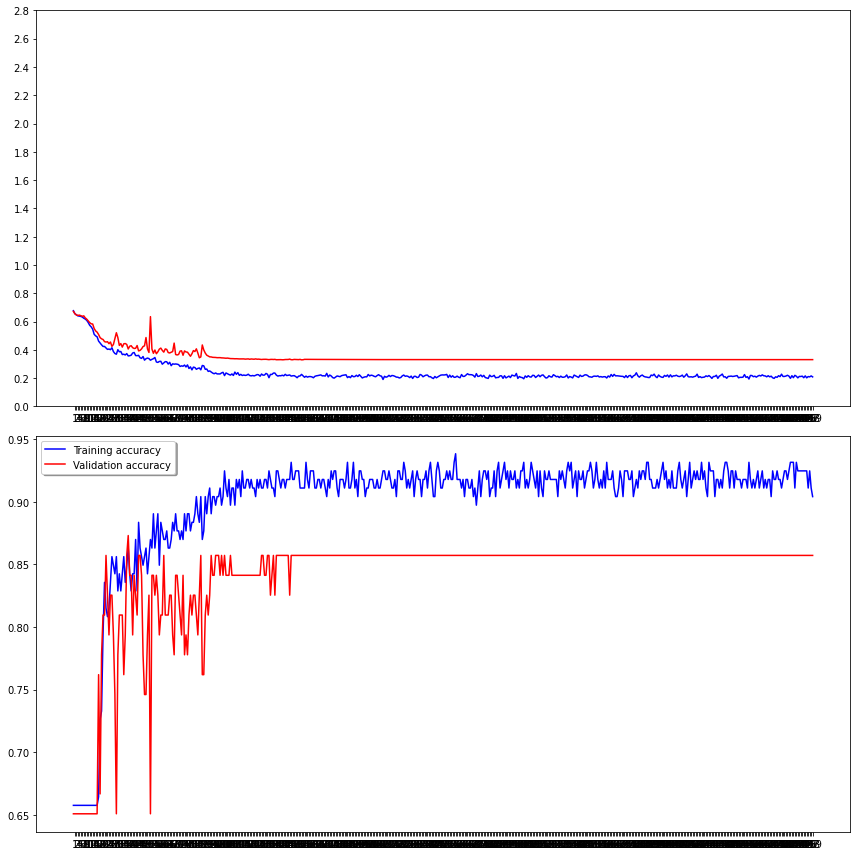

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 3, 0.2))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [31]:
test_filenames = os.listdir("input/test")

test_categories = []
for filename in test_filenames:
    category = filename.split('.')[0]
    if category == 'cat':
        test_categories.append(1)
    else:
        test_categories.append(0)

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})
nb_samples = test_df.shape[0]
nb_samples

50

In [32]:
test_df.head()

,filename,category
0,cat.0.jpg,1
1,cat.1.jpg,1
2,cat.10.jpg,1
3,cat.11.jpg,1
4,cat.12.jpg,1


<AxesSubplot:>

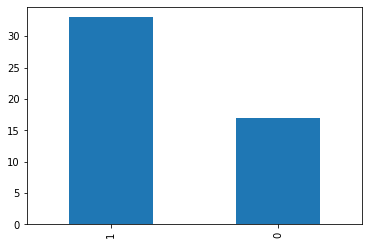

In [109]:
test_df['category'].value_counts().plot.bar()

In [34]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  50 non-null     object
 1   category  50 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 928.0+ bytes


# Create Testing Generator

In [35]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "input/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 50 validated image filenames.


# Predict

In [36]:
predict = model.predict(test_generator, steps=nb_samples)

In [37]:
predict

array([[9.6916580e-01, 3.0834129e-02],
       [9.6725118e-01, 3.2748848e-02],
       [9.5492297e-01, 4.5077030e-02],
       [9.5916462e-01, 4.0835407e-02],
       [9.6116602e-01, 3.8833987e-02],
       [1.8425788e-01, 8.1574208e-01],
       [9.0787321e-01, 9.2126712e-02],
       [7.8988969e-01, 2.1011028e-01],
       [5.2291316e-01, 4.7708690e-01],
       [6.1522233e-01, 3.8477772e-01],
       [9.1965234e-01, 8.0347672e-02],
       [9.6726614e-01, 3.2733802e-02],
       [9.6544367e-01, 3.4556258e-02],
       [8.5008472e-01, 1.4991523e-01],
       [9.6701080e-01, 3.2989219e-02],
       [9.6178788e-01, 3.8212128e-02],
       [9.6832812e-01, 3.1671867e-02],
       [9.6761715e-01, 3.2382797e-02],
       [9.6772993e-01, 3.2270085e-02],
       [7.6819378e-01, 2.3180622e-01],
       [9.6187919e-01, 3.8120829e-02],
       [9.4195735e-01, 5.8042672e-02],
       [9.6246034e-01, 3.7539642e-02],
       [6.4090437e-01, 3.5909563e-01],
       [9.6121301e-05, 9.9990392e-01],
       [8.0383444e-01, 1.

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [38]:
test_df['predicted'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [39]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['predicted'] = test_df['predicted'].replace(label_map)
display(test_df['predicted'].head())

0    cat
1    cat
2    cat
3    cat
4    cat
Name: predicted, dtype: object

From our prepare data part. We map data with `{1: 'noncat', 0: 'cat'}`. Now we will map the result back to cat is 1 and noncat is 0

In [40]:
test_df['predicted'] = test_df['predicted'].replace({ 'cat': 1, 'noncat': 0 })

In [41]:
test_df.head()

,filename,category,predicted
0,cat.0.jpg,1,1
1,cat.1.jpg,1,1
2,cat.10.jpg,1,1
3,cat.11.jpg,1,1
4,cat.12.jpg,1,1


### Virtaulize Result

<AxesSubplot:>

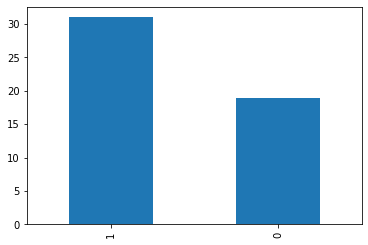

In [42]:
test_df['predicted'].value_counts().plot.bar()

### See predicted result with images

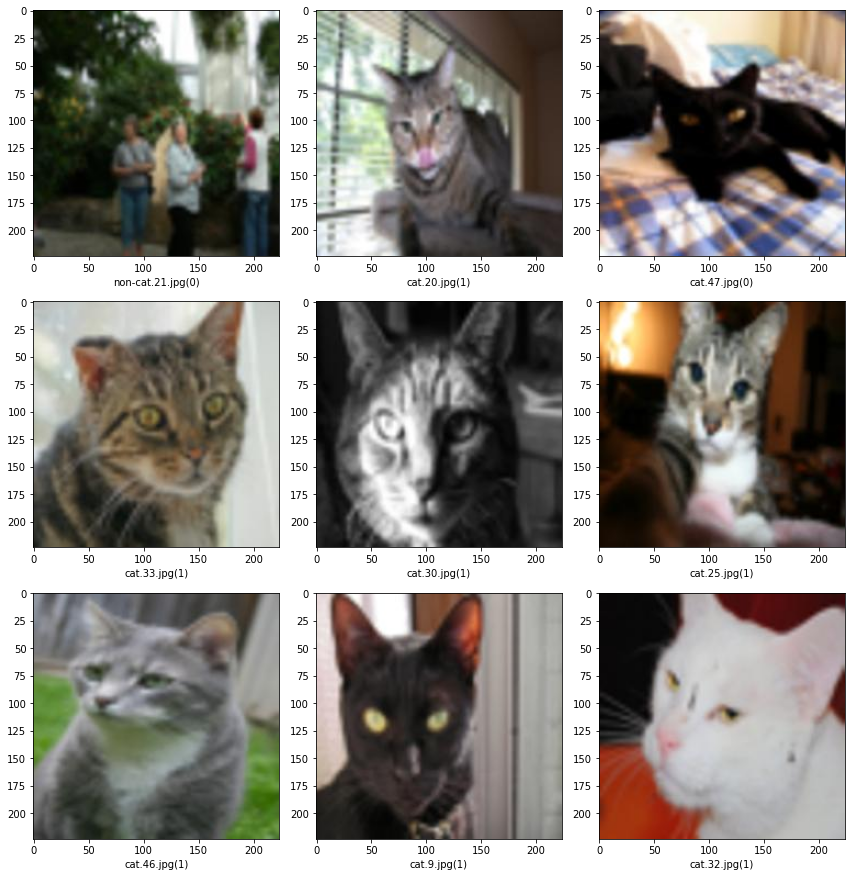

In [43]:
sample_test = test_df.sample(9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['predicted']
    img = load_img("input/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Accuracy

In [44]:
accuracy_score(test_df['category'].values,test_df['predicted'].values)

0.92

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio
from skimage.transform import resize
file_name = 'cat5.jpeg'
image = np.array(imageio.imread(file_name, as_gray=False))
my_image = resize(image, (224, 224))

In [103]:
type(image)

numpy.ndarray

In [104]:
image.shape

(197, 197, 3)

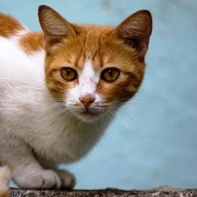

In [105]:
Image.open(file_name)

In [106]:
my_image.shape

(224, 224, 3)

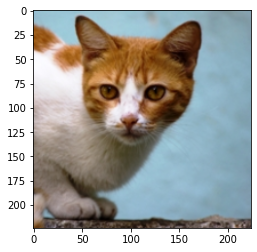

In [107]:
plt.imshow(my_image)

In [108]:
pred = model.predict(my_image.reshape(1, 224, 224,3))
display(pred, np.argmax(pred))

array([[0.08779895, 0.91220105]], dtype=float32)

1

# Analysis of results